In [ ]:
#default_exp core
#default_cls_lvl 3

In [ ]:
#export
from fastcore.test import *
from timeseries_fastai.imports import *

In [ ]:
#export
import pandas as pd
from fastcore.all import *
from scipy.io import arff

# Core

> Basic timeseries opening/processing funcs.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export
def maybe_unsqueeze(x):
    "Add empty dimension if it is a rank 1 tensor/array"
    if isinstance(x, np.ndarray): return x[None,:] if len(x.shape)==1 else x
    if isinstance(x, Tensor): return x.unsqueeze(0) if len(x.shape)==1 else x
    else: return None

In [ ]:
a = np.random.random(10)
test_eq((1,10), maybe_unsqueeze(a).shape)
test_eq((1,10), maybe_unsqueeze(maybe_unsqueeze(a)).shape) #do nothing

t = torch.rand(10)
test_eq((1,10), maybe_unsqueeze(t).shape)
test_eq((1,10), maybe_unsqueeze(maybe_unsqueeze(t)).shape) #do nothing

A time series is just an array of 1 dimesion.

In [ ]:
#export
def show_array(array, ax=None, figsize=None, title=None, ctx=None, tx=None, **kwargs):
    "Show an array on `ax`."
    # Handle pytorch axis order
    if hasattrs(array, ('data','cpu','permute')):
        array = array.data.cpu()
    elif not isinstance(array,np.ndarray):
        array=array(array)
    arrays = maybe_unsqueeze(array)
    ax = ifnone(ax,ctx)
    if figsize is None: figsize = (5,5)
    if ax is None: _,ax = plt.subplots(figsize=figsize)
    tx = ifnone(tx,np.arange(arrays[0].shape[0]))
    label = kwargs.pop('label', 'x')
    for a, c in zip(arrays, ['b', 'c', 'm', 'y', 'k',]):
        ax.plot(tx, a, '-'+c,label=label, **kwargs)
    if title is not None: ax.set_title(title)
    ax.legend()
    return ax

A simple array of 1 channel is `np.arange(10)`.

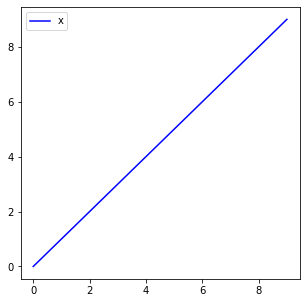

In [ ]:
show_array(np.arange(10));

In [ ]:
# export
class TSeries(TensorBase):
    "Basic Timeseries wrapper"  
    @classmethod
    def create(cls, x): 
        return cls(maybe_unsqueeze(x))
    
    @property
    def channels(self): return self.shape[0]
    
    @property
    def len(self): return self.shape[-1]
    
    def __repr__(self):
        return f'TSeries(ch={self.channels}, len={self.len})'
    
    def show(self, ctx=None, **kwargs):
        return show_array(self, ctx=ctx, **kwargs)

We can add some noise for the fun

In [ ]:
a = np.arange(10)+np.random.randn(10)

In [ ]:
a.shape

(10,)

As we want to make explicit that is a one channel timeseries, we will `unsqueeze` the first dimension.

In [ ]:
ts = TSeries.create(a)

In [ ]:
ts.data

tensor([[1.6348, 1.0677, 2.4319, 2.8330, 5.3104, 6.0821, 6.4813, 8.1038, 9.0339,
         8.1638]])

In [ ]:
ts.shape

torch.Size([1, 10])

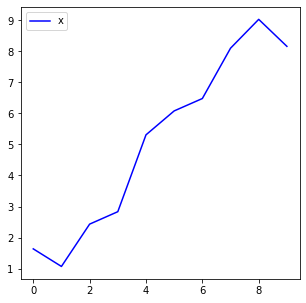

In [ ]:
ts.show();

In [ ]:
ts.data.mean()

tensor(5.1143)

In [ ]:
@patch
def encodes(self:Normalize, x:TSeries): return (x - self.mean) / self.std

@patch
def encodes(self: Normalize, x:TSeries): 
    f = to_cpu if x.device.type=='cpu' else noop
    return (x*f(self.std) + f(self.mean))

In [ ]:
nrm = Normalize(ts.data.mean(), ts.data.std())

<AxesSubplot:>

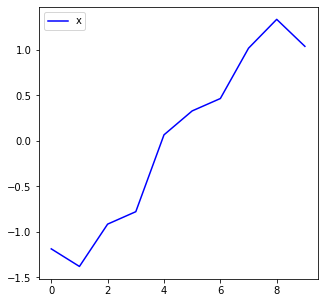

In [ ]:
((ts-nrm.mean)/ts.data.std()).show()

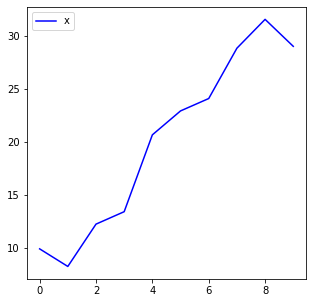

In [ ]:
nrm.encodes(ts).show();

## UCR
> The 2018 UCR 128-timeseries dataset

This is the dataset used to benchmark algorithms for Timeseries classification.

In [ ]:
#export
URLs.UCR = 'http://www.timeseriesclassification.com/Downloads/Archives/Univariate2018_arff.zip'

In [ ]:
URLs.UCR

'http://www.timeseriesclassification.com/Downloads/Archives/Univariate2018_arff.zip'

This link has a little problem, that unzips to `Univariate_arff.zip` instead of `Univariate2018_arff.zip`

In [ ]:
ucr_path = untar_data(URLs.UCR)

In [ ]:
ucr_path

Path('/home/tcapelle/.fastai/data/Univariate2018_arff')

In [ ]:
ucr_path.exists()

True

In [ ]:
URLs.path(URLs.UCR)

Path('/home/tcapelle/.fastai/archive/Univariate2018_arff.zip')

In [ ]:
zf = zipfile.ZipFile(URLs.path(URLs.UCR))

In [ ]:
zf.namelist()[0]

'Univariate_arff/'

In [ ]:
#export
@delegates(untar_data)
def get_ucr(**kwargs):
    "zipped file has different name as .zip"
    ucr_path = untar_data(URLs.UCR, **kwargs)
    if not ucr_path.exists():
        zf = zipfile.ZipFile(URLs.path(URLs.UCR))
        actual_folder = ucr_path.parent/zf.namelist()[0]
        actual_folder.rename(ucr_path)
        print(f'Renaming {actual_folder} to {ucr_path}')       
    return ucr_path

we rename with the 2018 at the end of the filename

In [ ]:
ucr_path = get_ucr()

In [ ]:
ucr_path

Path('/home/tcapelle/.fastai/data/Univariate2018_arff')

Each sub task is on a subfolde with task name. For instance we will select 'Adiac' .

In [ ]:
ucr_path.ls()

(#135) [Path('/home/tcapelle/.fastai/data/Univariate2018_arff/GestureMidAirD2'),Path('/home/tcapelle/.fastai/data/Univariate2018_arff/Adiac'),Path('/home/tcapelle/.fastai/data/Univariate2018_arff/CinCECGTorso'),Path('/home/tcapelle/.fastai/data/Univariate2018_arff/LargeKitchenAppliances'),Path('/home/tcapelle/.fastai/data/Univariate2018_arff/MixedShapesRegularTrain'),Path('/home/tcapelle/.fastai/data/Univariate2018_arff/ShakeGestureWiimoteZ'),Path('/home/tcapelle/.fastai/data/Univariate2018_arff/SmallKitchenAppliances'),Path('/home/tcapelle/.fastai/data/Univariate2018_arff/CricketY'),Path('/home/tcapelle/.fastai/data/Univariate2018_arff/ToeSegmentation2'),Path('/home/tcapelle/.fastai/data/Univariate2018_arff/EOGVerticalSignal')...]

In [ ]:
adiac_path = ucr_path/'Adiac'

In [ ]:
adiac_path.ls()

(#5) [Path('/home/tcapelle/.fastai/data/Univariate2018_arff/Adiac/Adiac_TEST.txt'),Path('/home/tcapelle/.fastai/data/Univariate2018_arff/Adiac/Adiac_TEST.arff'),Path('/home/tcapelle/.fastai/data/Univariate2018_arff/Adiac/Adiac_TRAIN.arff'),Path('/home/tcapelle/.fastai/data/Univariate2018_arff/Adiac/Adiac_TRAIN.txt'),Path('/home/tcapelle/.fastai/data/Univariate2018_arff/Adiac/Adiac.txt')]

We can find `.csv` and `.arff` files on this copy of the dataset. We will read the `.arff` files using a helper function. We will store them on pandas DataFrame's

In [ ]:
#export
# "this functions are based on https://github.com/mb4310/Time-Series"
def load_df_ucr(path, task):
    "Loads arff files from UCR pandas dfs"
    try:
        print(f'Loading files from: {path}/{task}')
        dfs = []
        for file in ['TRAIN', 'TEST']:
            filename = f'{task}/{task}_{file}.arff'
            data = arff.loadarff(str(path/filename))
            dfs.append(pd.DataFrame(data[0]))
        return dfs
    except:
        print(f'Error loading files: {path}/{task}')

In [ ]:
df_train, df_test = load_df_ucr(ucr_path, 'StarLightCurves')

Loading files from: /home/tcapelle/.fastai/data/Univariate2018_arff/StarLightCurves


In [ ]:
df_train.head()

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att1016,att1017,att1018,att1019,att1020,att1021,att1022,att1023,att1024,target
0,0.537303,0.531103,0.528503,0.529403,0.533603,0.540903,0.551103,0.564003,0.579603,0.597603,...,0.546903,0.545903,0.543903,0.541003,0.537203,0.532303,0.526403,0.519503,0.511403,b'3'
1,0.588398,0.593898,0.599098,0.604098,0.608798,0.613397,0.617797,0.622097,0.626097,0.630097,...,0.237399,0.246499,0.256199,0.266499,0.277399,0.288799,0.300899,0.313599,0.326899,b'3'
2,-0.049900,-0.041500,-0.033400,-0.025600,-0.018100,-0.010800,-0.003800,0.003000,0.009600,0.015900,...,-0.173801,-0.161601,-0.149201,-0.136401,-0.123201,-0.109701,-0.095901,-0.081701,-0.067100,b'1'
3,1.337005,1.319805,1.302905,1.286305,1.270005,1.254005,1.238304,1.223005,1.208104,1.193504,...,1.288905,1.298505,1.307705,1.316505,1.324905,1.332805,1.340205,1.347005,1.353205,b'3'
4,0.769801,0.775301,0.780401,0.785101,0.789401,0.793301,0.796801,0.799901,0.802601,0.805101,...,0.742401,0.744501,0.747301,0.750701,0.754801,0.759501,0.765001,0.771301,0.778401,b'3'


In [ ]:
#export
# "this functions are based on https://github.com/mb4310/Time-Series"
def load_np_ucr(path, task):
    "Loads arff files from UCR into np arrays"
    try:
        print(f'Loading files from: {path}/{task}')
        arrays = []
        for file in ['TRAIN', 'TEST']:
            filename = f'{task}/{task}_{file}.arff'
            data = arff.loadarff(str(path/filename))
            x,y = [],[]
            for r in data[0]:
                r = list(r)
                x.append(r[0:-1])
                y.append(r[-1])
            x = array(x, dtype=np.float)
            y = array(y, dtype=np.int)
            arrays += [x,y]
        return arrays
    except:
        print(f'Error loading files: {path}/{task}')

In [ ]:
x_train, y_train, x_test, y_test = load_np_ucr(ucr_path, 'StarLightCurves')

Loading files from: /home/tcapelle/.fastai/data/Univariate2018_arff/StarLightCurves


In [ ]:
test_eq(len(x_train), len(y_train))
test_eq(len(x_test), len(y_test))

## Datasets

Loading from `DataFrames`

In [ ]:
def get_x(row):
    return row.values[:-1].astype('float32')
def get_y(row):
    return int(row.values[-1])

In [ ]:
x_cols = df_train.columns[slice(0,-1)].to_list()
x_cols[0:5]

['att1', 'att2', 'att3', 'att4', 'att5']

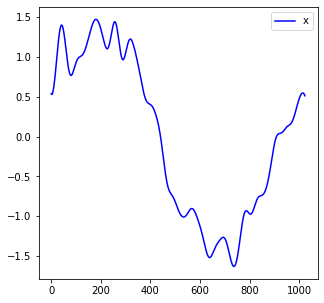

In [ ]:
TSeries(get_x(df_train.iloc[0])).show();

In [ ]:
splits = [list(range(len(df_train))), list(range(len(df_train), len(df_train)+len(df_test)))]

In [ ]:
ds = Datasets(pd.concat([df_train, df_test]).reset_index(drop=True), 
                    tfms=[[get_x, TSeries.create], [get_y, Categorize()]],
                    splits=splits, 
                   )

In [ ]:
ds.valid

(#8236) [(TSeries(ch=1, len=1024), TensorCategory(1)),(TSeries(ch=1, len=1024), TensorCategory(2)),(TSeries(ch=1, len=1024), TensorCategory(2)),(TSeries(ch=1, len=1024), TensorCategory(0)),(TSeries(ch=1, len=1024), TensorCategory(1)),(TSeries(ch=1, len=1024), TensorCategory(2)),(TSeries(ch=1, len=1024), TensorCategory(2)),(TSeries(ch=1, len=1024), TensorCategory(2)),(TSeries(ch=1, len=1024), TensorCategory(1)),(TSeries(ch=1, len=1024), TensorCategory(2))...]

In [ ]:
dls = ds.dataloaders(bs=2)

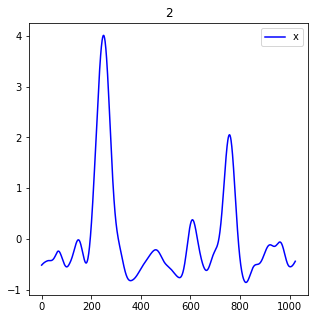

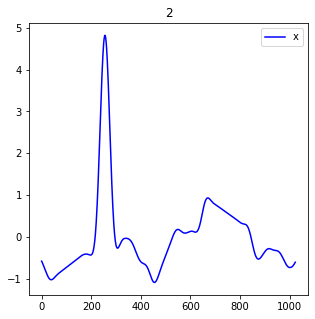

In [ ]:
dls.show_batch()

## Loading from arrays:

In [ ]:
class NumpyDataset(torch.utils.data.Dataset):
    def __init__(self, X, y=None):
        self.X, self.y = X, y

    def __getitem__(self, idx):
        if self.y is None: return (self.X[idx], )
        else: return (TSeries.create(self.X[idx]), TensorCategory(self.y[idx]))

    def __len__(self):
        return len(self.X)

In [ ]:
ds_train = NumpyDataset(x_train, y_train)
ds_valid = NumpyDataset(x_test, y_test)

In [ ]:
ds_train[0][0].data.shape

torch.Size([1, 1024])

In [ ]:
dls = DataLoaders.from_dsets(ds_train, ds_valid, bs=8)

In [ ]:
dls.train.one_batch()

(TSeries(ch=64, len=1024),
 TensorCategory([3, 3, 1, 3, 2, 2, 2, 3, 3, 2, 1, 3, 3, 2, 2, 2, 1, 3, 3, 2, 3, 1, 3, 3,
         2, 3, 2, 1, 3, 3, 2, 3, 2, 3, 3, 3, 2, 2, 2, 3, 1, 3, 3, 3, 2, 3, 3, 3,
         2, 2, 3, 3, 3, 1, 3, 3, 2, 3, 1, 3, 3, 3, 3, 2]))

In [ ]:
%time cycle_dl(dls.valid)

CPU times: user 128 ms, sys: 180 ms, total: 308 ms
Wall time: 559 ms


In [ ]:
class TSTransform(Transform):
    def __init__(self, x, y):
        self.x, self.y = x, y
        
    def encodes(self, i):
        return (TSeries.create(self.x[i]), TensorCategory(self.y[i]))

In [ ]:
train_tl = TfmdLists(range_of(x_train), TSTransform(x_train, y_train))
valid_tl = TfmdLists(range_of(x_test), TSTransform(x_test, y_test))

In [ ]:
train_tl[0:5]

(#5) [(TSeries(ch=1, len=1024), TensorCategory(3)),(TSeries(ch=1, len=1024), TensorCategory(3)),(TSeries(ch=1, len=1024), TensorCategory(1)),(TSeries(ch=1, len=1024), TensorCategory(3)),(TSeries(ch=1, len=1024), TensorCategory(3))]

In [ ]:
dls = DataLoaders.from_dsets(train_tl, valid_tl, bs=8)

In [ ]:
tx, ty = dls.one_batch()

In [ ]:
def cycle_dl(dl):
    for x,y in iter(dl):
        pass

In [ ]:
%timeit cycle_dl(dls.valid)

639 ms ± 47.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
val_dl =TfmdDL(valid_tl, bs=8)

In [ ]:
%timeit cycle_dl(val_dl)

1.25 s ± 43.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
class Slicer:
    "slice numpy ds"
    def __init__(self,to): self.to = to
    def __getitem__(self, idxs):
        return self.to.new(*self.to[idxs])

class NumpyDataset2():
    def __init__(self, X, y=None):
        self.X, self.y = X, y

    def __getitem__(self, idx):
        if self.y is None: return (self.X[idx], )
        else: return (self.X[idx], self.y[idx])

    def __len__(self):
        return len(self.X)

    @property
    def slicer(self):
        return Slicer(self)

    def new(self, X, y):
        return type(self)(X, y)

In [ ]:
ds = NumpyDataset2(x,y)

In [ ]:
ds.slicer[0:3]

In [ ]:
class ReadTSBatch(ItemTransform):
    def __init__(self, to): self.to = to

    def encodes(self, to):
        res = (tensor(to.X).float(), )
        res = res + (tensor(to.y),)
        # if to.device is not None: res = to_device(res, to.device)
        return res


In [ ]:
rtsb = ReadTSBatch(ds)
tx,ty = rtsb.encodes(ds.slicer[0:8])

In [ ]:
tx.shape, ty.shape

(torch.Size([8, 1, 1024]), torch.Size([8]))

In [ ]:
class TSDataloader(TfmdDL):
    do_item = noops
    def __init__(self, dataset, bs=16, shuffle=False, after_batch=None, num_workers=0, **kwargs):
        if after_batch is None: after_batch = L(TransformBlock().batch_tfms)+ReadTSBatch(dataset)
        super().__init__(dataset, bs=bs, shuffle=shuffle, after_batch=after_batch, num_workers=num_workers, **kwargs)

    def create_batch(self, b): return self.dataset.slicer[b]

In [ ]:
dl = TSDataloader(ds, 8)

In [ ]:
%timeit cycle_dl(dl)

946 µs ± 5.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [ ]:
len(dl.dataset)

64

# Export -

In [ ]:
# hide
from nbdev.export import *
notebook2script()

Converted 00_core.ipynb.
Converted 01_data.ipynb.
Converted 02_models.ipynb.
Converted 03_tabular.ipynb.
Converted 04_testing.ipynb.
Converted 99_index.ipynb.
